## Multi-temporal RGB composite 2016

### Import the Python packages

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

from shapely.wkt import loads 
from shapely.geometry import box
from shapely.geometry import Point
from shapely import geometry

import osr
import ogr

import gdal
from geopandas import GeoDataFrame
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import ellip_snap_helpers

from PIL import Image

%load_ext autoreload
%autoreload 2

### Search parameters

Set the catalogue endpoint to Sentinel-1:

In [2]:
series = 'https://catalog.terradue.com/sentinel1/search'

Define the time of interest:

In [3]:
tois = {'winter': { 'start_date': '2016-01-01T00:00:00Z', 'stop_date': '2016-01-31T23:59:59Z' },
        'mid_summer': { 'start_date': '2016-07-01T00:00:00Z', 'stop_date': '2016-07-31T23:59:59Z' },
        'late_summer': { 'start_date': '2016-08-15T00:00:00Z', 'stop_date': '2016-08-31T23:59:59Z' }}

In [4]:
for index, toi in enumerate(tois):
    print toi, tois[toi]['start_date'], tois[toi]['stop_date']

mid_summer 2016-07-01T00:00:00Z 2016-07-31T23:59:59Z
late_summer 2016-08-15T00:00:00Z 2016-08-31T23:59:59Z
winter 2016-01-01T00:00:00Z 2016-01-31T23:59:59Z


Define the area of interest:

In [5]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [6]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [7]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [8]:
extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

### Build and submit the catalog search


In [9]:
results = []

for index, toi in enumerate(tois):
    
    print toi
    
    search_params = dict([('geom', extended_aoi),
                          ('start', tois[toi]['start_date']),
                          ('stop', tois[toi]['stop_date']),
                          ('track', '117'),
                          ('pt', 'GRD'),
                          ('psn', 'S1A'),
                          ('do','terradue'),
                          ('count', 1)])
    
    print search_params

    search = ciop.search(end_point = series,
                     params = search_params,
                     output_fields='self,enclosure,identifier,startdate,wkt', 
                     model='GeoTime')
    
    print search[0]['identifier']    
    results.append(search[0])

results = GeoDataFrame(results)

mid_summer
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '117', 'stop': '2016-07-31T23:59:59Z', 'start': '2016-07-01T00:00:00Z', 'geom': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'}
S1A_EW_GRDM_1SDH_20160722T171729_20160722T171829_012264_0130ED_69F8
late_summer
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '117', 'stop': '2016-08-31T23:59:59Z', 'start': '2016-08-15T00:00:00Z', 'geom': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'}
S1A_EW_GRDM_1SDH_20160827T171731_20160827T171831_012789_014273_2C0D
winter
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '117', 'stop': '2016-01-31T23:59:59Z', 'start': '2016-01-01T00:00:00Z', 'geom': 'POLY

In [10]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160722T171729_20160722T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-07-22T17:17:29.8771050Z,"POLYGON((-63.618748 83.5718,-43.978619 87.0112..."
1,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160827T171731_20160827T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-08-27T17:17:31.7416870Z,"POLYGON((-63.622292 83.570732,-43.992443 87.01..."
2,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160124T171723_20160124T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-01-24T17:17:23.6167430Z,"POLYGON((-63.617699 83.569885,-43.976994 87.01..."


In [11]:
results['startdate'] = pd.to_datetime(results['startdate']) 
results['wkt'] = results['wkt'].apply(loads)

In [12]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160722T171729_20160722T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-07-22 17:17:29.877105,"POLYGON ((-63.618748 83.5718, -43.978619 87.01..."
1,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160827T171731_20160827T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-08-27 17:17:31.741687,"POLYGON ((-63.622292 83.57073200000001, -43.99..."
2,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160124T171723_20160124T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-01-24 17:17:23.616743,"POLYGON ((-63.617699 83.569885, -43.976994 87...."


In [13]:
def analyse(row, aoi_wkt):

    aoi = loads(aoi_wkt)

    aoi_intersection = (row['wkt'].intersection(aoi).area / aoi.area) * 100
        
    series = dict([('aoi_intersection', aoi_intersection)])
    
    return pd.Series(series)

In [14]:
results = results.merge(results.apply(lambda row: analyse(row, extended_aoi), axis=1), 
              left_index=True,
              right_index=True)

In [15]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection
0,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160722T171729_20160722T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-07-22 17:17:29.877105,"POLYGON ((-63.618748 83.5718, -43.978619 87.01...",100.0
1,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160827T171731_20160827T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-08-27 17:17:31.741687,"POLYGON ((-63.622292 83.57073200000001, -43.99...",100.0
2,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160124T171723_20160124T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-01-24 17:17:23.616743,"POLYGON ((-63.617699 83.569885, -43.976994 87....",100.0


In [16]:
target_dir = '/workspace/data2'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

def stage_in(row):
    
    local_path = ciop.copy(row['enclosure'], extract=False, target=target_dir)
    row['local_path'] = local_path
        
    return row 
    

In [17]:
results = results.apply(lambda row: stage_in(row), axis=1)

In [18]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path
0,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160722T171729_20160722T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-07-22 17:17:29.877105,"POLYGON ((-63.618748 83.5718, -43.978619 87.01...",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160722T171...
1,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160827T171731_20160827T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-08-27 17:17:31.741687,"POLYGON ((-63.622292 83.57073200000001, -43.99...",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160827T171...
2,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160124T171723_20160124T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-01-24 17:17:23.616743,"POLYGON ((-63.617699 83.569885, -43.976994 87....",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160124T171...


### Process sigma0

In [19]:
def sigma0(row, aoi):
    
    local_path = row['local_path']
    identifier = row['identifier']
    
    mygraph = ellip_snap_helpers.GraphProcessor()
    
    operator = 'Read'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = local_path 
    mygraph.add_node(operator,
                     operator, 
                     parameters,
                     '') 
    
    operator = 'ThermalNoiseRemoval'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Read')
    

    operator = 'Apply-Orbit-File'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator, 
                     parameters, 
                     'ThermalNoiseRemoval')



    operator = 'Calibration'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters, 
                     'Apply-Orbit-File')


    operator = 'Speckle-Filter'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator,
                     parameters, 
                     'Calibration')


    operator = 'Multilook'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Speckle-Filter')


    operator = 'LinearToFromdB'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Multilook')


    operator = 'Terrain-Correction'

    map_proj = """PROJCS["WGS 84 / North Pole LAEA Europe",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","3575"]]"""

    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['demName'] = 'ACE30'  
    parameters['saveDEM'] = 'true'
    parameters['mapProjection'] = map_proj
    parameters['nodataValueAtSea'] = 'false'   
                

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'LinearToFromdB')

    operator = 'Subset'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['geoRegion'] = aoi 

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Terrain-Correction')


    operator = 'Write'
    
    output_name = 'SIGMA0_%s' % identifier
    
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = output_name
    parameters['formatName'] = 'GeoTIFF-BigTiff'
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Subset')

    mygraph.run()
    
    row['sigma0'] = output_name + '.tif'
    
    return row

In [20]:
results = results.apply(lambda row: sigma0(row, extended_aoi), axis=1)

Processing the graph
Process PID: 29547
Executing processing graph
...12%..22%..32%...45%...57%..67%..77%...89% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.engine_utilities.download.downloadablecontent.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1A/2016/07/S1A_OPER_AUX_POEORB_OPOD_20160811T121558_V20160721T225943_20160723T005943.EOF.zip

Done.
Processing the graph
Process PID: 29632
Executing processing graph
...12%..22%..32%...45%...57%..67%..77%...89% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.engine_utilities.download.downloadablecontent.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1A/2016/08/S1A_OPER_AUX_PO

In [21]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path,sigma0
0,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160722T171729_20160722T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-07-22 17:17:29.877105,"POLYGON ((-63.618748 83.5718, -43.978619 87.01...",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160722T171...,SIGMA0_S1A_EW_GRDM_1SDH_20160722T171729_201607...
1,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160827T171731_20160827T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-08-27 17:17:31.741687,"POLYGON ((-63.622292 83.57073200000001, -43.99...",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160827T171...,SIGMA0_S1A_EW_GRDM_1SDH_20160827T171731_201608...
2,https://store.terradue.com/download/sentinel1/...,S1A_EW_GRDM_1SDH_20160124T171723_20160124T1718...,https://catalog.terradue.com/sentinel1/search?...,2016-01-24 17:17:23.616743,"POLYGON ((-63.617699 83.569885, -43.976994 87....",100.0,/workspace/data2/S1A_EW_GRDM_1SDH_20160124T171...,SIGMA0_S1A_EW_GRDM_1SDH_20160124T171723_201601...


In [22]:
sigma0s = list(results['sigma0'].values)

In [23]:
sigma0s

['SIGMA0_S1A_EW_GRDM_1SDH_20160722T171729_20160722T171829_012264_0130ED_69F8.tif',
 'SIGMA0_S1A_EW_GRDM_1SDH_20160827T171731_20160827T171831_012789_014273_2C0D.tif',
 'SIGMA0_S1A_EW_GRDM_1SDH_20160124T171723_20160124T171823_009639_00E0BC_2126.tif']

In [24]:
ds = gdal.Open(sigma0s[0])

geo_transform = ds.GetGeoTransform()
proj = ds.GetProjection()

srs=osr.SpatialReference(wkt=proj)

w = ds.GetRasterBand(1).XSize
h = ds.GetRasterBand(1).YSize

ds = None

In [25]:
bands = []

min_db = -26
max_db = 6

rgb_name = 'multitemporal_rgb_2017' + '.tif'
    
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
    
dst_ds = gdal.GetDriverByName('GTiff').Create(rgb_name, w, h, 3, gdal.GDT_Byte, options=options)
    
dst_ds.SetGeoTransform(geo_transform)   
 
dst_ds.SetProjection(srs.ExportToWkt()) 

for index, tif in enumerate(sigma0s):
    
    raster = gdal.Open(tif)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray(0, 0, w, h)
    
    band_dest = (array * 255 / (max_db - min_db))
    
    bands.append(band_dest)
    
    dst_ds.GetRasterBand(index + 1).WriteArray(band_dest.astype(np.uint8))
    
dst_ds.FlushCache()                    
dst_ds = None

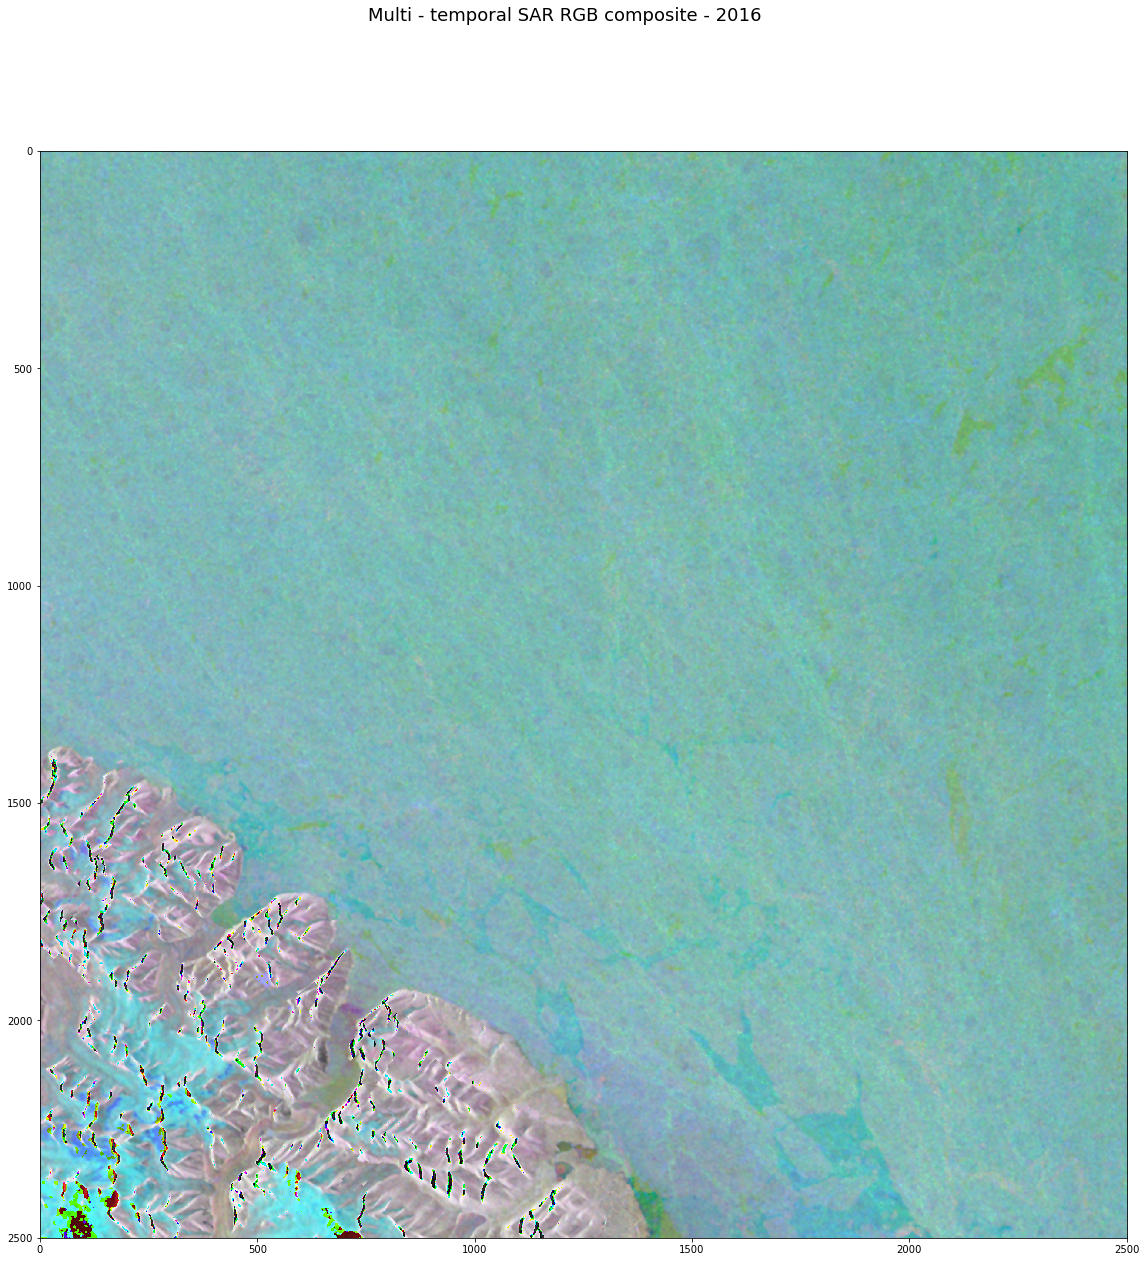

In [26]:
rgb_uint8 = np.dstack(bands).astype(np.uint8) 

width = 20
height = 20
fig = plt.figure(figsize=(width, height))
fig.suptitle('Multi - temporal SAR RGB composite - 2016', fontsize=18)
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)